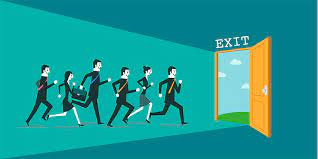

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [ ]:
df.head()

In [ ]:
df.isna().sum()

In [ ]:
df.info()

In [ ]:
df.loc[488]

In [ ]:
df[df['TotalCharges'] == " "]

In [ ]:
indexes = df[df['TotalCharges'] == " "]["TotalCharges"].index

In [ ]:
for i in indexes:
    df.at[i, "TotalCharges"] = "0.0"

In [ ]:
df["TotalCharges"] = df["TotalCharges"].astype(float)

In [ ]:
df.describe()

In [ ]:
df.describe(exclude="number").T

In [ ]:
cat_feats = [x for x in df.columns if df[x].dtype == "object" and x != "customerID"]
num_feats = [x for x in df.columns if df[x].dtype != "object"]

In [ ]:
cat_feats

In [ ]:
sns.countplot(x=df["Churn"])

In [ ]:
fig = plt.figure(figsize=(18, 30))

for i, col in enumerate(cat_feats):
    plt.subplot(10, 3, i+1)
    sns.countplot(x=df[col])
    plt.tight_layout()
fig.show()

In [ ]:
fig = plt.figure(figsize=(15, 40))

for i, col in enumerate(num_feats):
    plt.subplot(10, 2, i+1)
    sns.boxplot(x="Churn", y=col, data=df)
    plt.tight_layout()
fig.show()

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x="Contract", y="TotalCharges", hue="Churn")
plt.legend(loc=(1.1, 0.5));

In [ ]:
df["Churn"] = df["Churn"].apply(lambda x: 0 if x=="No" else 1)

In [ ]:
num_feats.append("Churn")

In [ ]:
sns.heatmap(df[num_feats].corr(), annot=True)

In [ ]:
cat_feats.remove("Churn")

In [ ]:
df[num_feats]

In [ ]:
dummies_df = pd.get_dummies(df[cat_feats], drop_first=True)
new_df = pd.concat([dummies_df, df[num_feats]], axis=1)
new_df.head()

## Churn Analysis

In [ ]:
new_df = new_df.sample(frac=1).reset_index(drop=True)

In [ ]:
df["tenure"].unique()

In [ ]:
plt.figure(figsize=(14,5))
sns.histplot(data=df["tenure"], bins=60);

In [ ]:
sns.displot(data=df, x="tenure", bins=70, col="Contract", row="Churn")

In [ ]:
plt.figure(figsize=(10, 4), dpi=200)
sns.scatterplot(x=df["MonthlyCharges"], y=df["TotalCharges"], hue=df["Churn"], alpha=0.5,
                linewidth=0.3, palette="Dark2");

### Creating cohorts based on tenure

In [ ]:
df.groupby(["Churn", "tenure"]).count().transpose()[0]

In [ ]:
yes_churn = df.groupby(["Churn", "tenure"]).count().transpose()[1]
no_churn = df.groupby(["Churn", "tenure"]).count().transpose()[0]

In [ ]:
churn_rate = 100 * yes_churn / (no_churn + yes_churn)
churn_rate.head()

In [ ]:
plt.figure(figsize=(10,4))
churn_rate.transpose()["customerID"].plot()
plt.ylabel("Churn percentage");

### Broader Cohort Groups

- '0-12 Months'
- '12-24 Months'
- '24-48 Months'
- 'Over 48 Months'

In [ ]:
def cohort(tenure):
    if tenure < 13:
        return "0-12 Months"
    elif tenure < 25:
        return "12-24 Months"
    elif tenure < 49:
        return "24-48 Months"
    else:
        return "Over 48 Months"

In [ ]:
df["tenure_cohort"] = df["tenure"].apply(cohort)

In [ ]:
df[["tenure", "tenure_cohort"]]

In [ ]:
plt.figure(figsize=(10, 4), dpi=200)
sns.scatterplot(x=df["MonthlyCharges"], y=df["TotalCharges"], hue=df["tenure_cohort"], alpha=0.5,
                linewidth=0.3, palette="Dark2");

In [ ]:
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='tenure_cohort',hue="Churn", palette="Dark2");

In [ ]:
sns.catplot(data=df, x="tenure_cohort", hue="Churn", kind="count",
            col="Contract");

## Creating a model

In [ ]:
new_df.head()

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

In [ ]:
from sklearn.model_selection import StratifiedKFold

new_df["kfold"] = -1

skf = StratifiedKFold(n_splits=5)

for fold, (train_idx, valid_idx) in enumerate(skf.split(new_df, new_df["Churn"])):
    new_df.loc[valid_idx, "kfold"] = fold

In [ ]:
def run_training(df, algo, fold):
    
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)
    
    xtrain = train_df.drop(["Churn", "kfold"], axis=1)
    xvalid = valid_df.drop(["Churn", "kfold"], axis=1)

    ytrain = train_df.Churn.values
    yvalid = valid_df.Churn.values
    
    model = algo
    model.fit(xtrain, ytrain)
    preds = model.predict(xvalid)
    
    fold_acc = accuracy_score(yvalid, preds)
    print(f"fold={fold}, acc={fold_acc}")
    
    return fold_acc, model, preds

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix

In [ ]:
y = new_df["Churn"].values

In [ ]:
acc = []
all_preds = []
for f in range(5):
    dt = DecisionTreeClassifier()
    fold_acc, dt, preds = run_training(new_df, dt, f)
    acc.append(fold_acc)
    all_preds.append(preds)

print(f"Mean Acc={np.mean(acc)}")

all_pred = np.hstack(all_preds)
print(confusion_matrix(y, all_pred))
print(classification_report(y, all_pred))

In [ ]:
feat_imp = pd.DataFrame(dt.feature_importances_, index=new_df.drop(["Churn", "kfold"], axis=1).columns, columns=["Feat_Imp"])
feat_imp = feat_imp[feat_imp["Feat_Imp"] > 0].sort_values(by=["Feat_Imp"])
feat_imp.style.background_gradient(cmap="coolwarm")

In [ ]:
plt.figure(figsize=(14, 5), dpi=150)
sns.barplot(data=feat_imp, x=feat_imp.index, y="Feat_Imp", palette="coolwarm")
plt.xticks(rotation=90);

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

acc = []
all_preds = []
for f in range(5):
    rfc = RandomForestClassifier(n_estimators=200)
    fold_acc, dt, preds = run_training(new_df, rfc, f)
    acc.append(fold_acc)
    all_preds.append(preds)

print(f"Mean Acc={np.mean(acc)}")

all_pred = np.hstack(all_preds)
print(confusion_matrix(y, all_pred))
print(classification_report(y, all_pred))

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

**AdaBoost**

In [ ]:
acc = []
all_preds = []
for f in range(5):
    ada_model = AdaBoostClassifier(n_estimators=200)
    fold_acc, dt, preds = run_training(new_df, ada_model, f)
    acc.append(fold_acc)
    all_preds.append(preds)

print(f"Mean Acc={np.mean(acc)}")

all_pred = np.hstack(all_preds)
print(confusion_matrix(y, all_pred))
print(classification_report(y, all_pred))

**GradientBoosting**

In [ ]:
acc = []
all_preds = []
for f in range(5):
    gbc_model = GradientBoostingClassifier(n_estimators=200)
    fold_acc, dt, preds = run_training(new_df, gbc_model, f)
    acc.append(fold_acc)
    all_preds.append(preds)

print(f"Mean Acc={np.mean(acc)}")

all_pred = np.hstack(all_preds)
print(confusion_matrix(y, all_pred))
print(classification_report(y, all_pred))

**XGBoost**

In [ ]:
from xgboost import XGBClassifier

acc = []
all_preds = []
for f in range(5):
    xgb_model = XGBClassifier(use_label_encoder=False)
    fold_acc, dt, preds = run_training(new_df, xgb_model, f)
    acc.append(fold_acc)
    all_preds.append(preds)

print(f"Mean Acc={np.mean(acc)}")

all_pred = np.hstack(all_preds)
print(confusion_matrix(y, all_pred))
print(classification_report(y, all_pred))

**LogisticRegression**

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [ ]:
new_df

In [ ]:
def run_training2(df, algo, fold):
    
    train_df = df[df.kfold != fold].reset_index(drop=True)
    valid_df = df[df.kfold == fold].reset_index(drop=True)
    
    xtrain = train_df.drop(["Churn", "kfold"], axis=1)
    xvalid = valid_df.drop(["Churn", "kfold"], axis=1)
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(xtrain)
    xvalid = scaler.transform(xvalid)

    ytrain = train_df.Churn.values
    yvalid = valid_df.Churn.values
    
    model = algo
    model.fit(xtrain, ytrain)
    preds = model.predict(xvalid)
    
    fold_acc = accuracy_score(yvalid, preds)
    print(f"fold={fold}, acc={fold_acc}")
    
    return fold_acc, model, preds

In [ ]:
acc = []
all_preds = []
for f in range(5):
    lrcv_model = LogisticRegressionCV(max_iter=100000)
    fold_acc, lr, preds = run_training2(new_df, lrcv_model, f)
    acc.append(fold_acc)
    all_preds.append(preds)

print(f"Mean Acc={np.mean(acc)}")

all_pred = np.hstack(all_preds)
print(confusion_matrix(y, all_pred))
print(classification_report(y, all_pred))

**SupportVectorClassifier**

In [ ]:
from sklearn.svm import SVC

In [ ]:
acc = []
all_preds = []
for f in range(5):
    svc_model = SVC(C=1000)
    fold_acc, svc, preds = run_training(new_df, svc_model, f)
    acc.append(fold_acc)
    all_preds.append(preds)

print(f"Mean Acc={np.mean(acc)}")

all_pred = np.hstack(all_preds)
print(confusion_matrix(y, all_pred))
print(classification_report(y, all_pred))

**KNeighborsClassifer**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
acc = []
all_preds = []
for f in range(5):
    knn_model = KNeighborsClassifier(n_neighbors=10)
    fold_acc, svc, preds = run_training(new_df, knn_model, f)
    acc.append(fold_acc)
    all_preds.append(preds)

print(f"Mean Acc={np.mean(acc)}")

all_pred = np.hstack(all_preds)
print(confusion_matrix(y, all_pred))
print(classification_report(y, all_pred))